# Step-by-step demonstration

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss

sys.path.append("Codes/")

import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


## Loading event log

In [2]:
# Mapping all event_logs paths
logs_path = glob.glob("Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)/*")

# Removing the logs with 100 cases only events 
logs_path = [x for x in logs_path if "_baseline" not in x and "_100_" not in x and "_trace_" in x and "recurring" in x] # Trace perspective

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path).head(30)

How many logs?  150


,0
0,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_cb.csv
1,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_cd.csv
2,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_cf.csv
3,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_cp.csv
4,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_IOR.csv
5,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_IRO.csv
6,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_lp.csv
7,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_OIR.csv
8,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_pl.csv
9,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_pm.csv


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [3]:
# Loading first event log
log_path = logs_path[0]
print(log_path.split("\\")[-1].split(".")[0])
event_log = pd.read_csv(log_path)

# This is a specifc step for this event log that separates in different rows the start and end of an activity. As we will only use one timestamp, we are filtering only the row representing the end of an activity.  
# event_log = event_log[event_log.EventType == "complete"]

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# # This is a specifc step for this event log, because it have duplicated case ids. So we create a new case id.
# event_log["Trace_order"] = TMPD_utils.cumulative_counting(event_log["case"])

# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('case')))
print("Total activities: ", len(event_log.groupby('event')))
event_log.head(15)

recurring_trace_noise0_1000_cb
Total events:  10924
Total cases:  1000
Total activities:  15


,original_index,case,event,startTime,completeTime
0,0,0,A,2019/01/10 08:00:00.000,2019/01/10 08:00:00.000
1,1,1,A,2019/01/10 08:20:00.000,2019/01/10 08:20:00.000
2,2,0,B,2019/01/10 08:32:57.450,2019/01/10 08:32:57.450
3,3,2,A,2019/01/10 08:40:00.000,2019/01/10 08:40:00.000
4,4,1,D,2019/01/10 08:56:04.707,2019/01/10 08:56:04.707
5,5,3,A,2019/01/10 09:00:00.000,2019/01/10 09:00:00.000
6,6,0,C,2019/01/10 09:02:26.769,2019/01/10 09:02:26.769
7,7,2,B,2019/01/10 09:14:52.625,2019/01/10 09:14:52.625
8,8,4,A,2019/01/10 09:20:00.000,2019/01/10 09:20:00.000
9,9,1,F,2019/01/10 09:25:01.311,2019/01/10 09:25:01.311


## Step 1 - Instantiating class and setting event log

In [4]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='case', activity_key='event', timestamp_key='startTime', timestamp_format="infer", other_columns_keys=[])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head(30)

11924


,case_id,activity_from,timestamp_from,event_order_from,activity_to,timestamp_to,event_order_to,case_order,transition_id
0,0,START,2019-01-10 08:00:00.000,0,A,2019-01-10 08:00:00.000,0.0000,0,0
1,0,A,2019-01-10 08:00:00.000,0,B,2019-01-10 08:32:57.450,2.0000,1,1
2,1,START,2019-01-10 08:20:00.000,1,A,2019-01-10 08:20:00.000,1.0000,0,2
3,1,A,2019-01-10 08:20:00.000,1,D,2019-01-10 08:56:04.707,4.0000,1,3
4,0,B,2019-01-10 08:32:57.450,2,C,2019-01-10 09:02:26.769,6.0000,2,4
5,2,START,2019-01-10 08:40:00.000,3,A,2019-01-10 08:40:00.000,3.0000,0,5
6,2,A,2019-01-10 08:40:00.000,3,B,2019-01-10 09:14:52.625,7.0000,1,6
7,1,D,2019-01-10 08:56:04.707,4,F,2019-01-10 09:25:01.311,9.0000,2,7
8,3,START,2019-01-10 09:00:00.000,5,A,2019-01-10 09:00:00.000,5.0000,0,8
9,3,A,2019-01-10 09:00:00.000,5,B,2019-01-10 09:30:34.643,10.0000,1,9


## Step 2 - Setting Window Strategy

In [5]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 1000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 100, continuous = True)
# TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 1000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 1, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items())[:15])

{0: {'start': 0, 'end': 1000},
 1: {'start': 100, 'end': 1100},
 2: {'start': 200, 'end': 1200},
 3: {'start': 300, 'end': 1300},
 4: {'start': 400, 'end': 1400},
 5: {'start': 500, 'end': 1500},
 6: {'start': 600, 'end': 1600},
 7: {'start': 700, 'end': 1700},
 8: {'start': 800, 'end': 1800},
 9: {'start': 900, 'end': 1900},
 10: {'start': 1000, 'end': 2000},
 11: {'start': 1100, 'end': 2100},
 12: {'start': 1200, 'end': 2200},
 13: {'start': 1300, 'end': 2300},
 14: {'start': 1400, 'end': 2400}}

## Step 3 - Setting Process Representation (using Transition Matrix)

In [ ]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0
                                    , control_flow_features={'frequency', 'probability', 'causality', 'parallel', 'choice', 'loop'}
                                    , time_features={('time_avg','timestamp'), ('time_std','timestamp')}
                                    , resource_features={}
                                    , data_features={})

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation().head(15)

frequency  percentual  probability  causality  \
activity_from activity_to                                                  
A             B                 1028      0.0862       0.5069          0   
              D                  660      0.0554       0.3254          0   
              F                  340      0.0285       0.1677          0   
B             C                 1028      0.0862       1.0000          1   
C             A                 1028      0.0862       1.0000          1   
D             E                  340      0.0285       0.3400          0   
              F                  660      0.0554       0.6600          0   
E             G                 1000      0.0839       1.0000          1   
F             D                  340      0.0285       0.3400          0   
              E                  660      0.0554       0.6600          0   
G             H                  501      0.0420       0.5010          0   
              I                  421      0.0353       0.4210          0   
              K                   36      0.0030       0.0360          0   
              L                   42      0.0035       0.0420          0   
H             END                501      0.0420       1.0000          1   

                           parallel  time_std_timestamp  time_avg_timestamp  
activity_from activity_to                                                    
A             B                   0              3.0702             29.9577  
              D                   0              2.9318             29.8200  
              F                   0              3.0572             29.7820  
B             C                   0              3.0831             30.1949  
C             A                   0              2.9168             29.8397  
D             E                   0              2.9671             29.7414  
              F                   1              2.9173             29.9558  
E             G                   0              3.0036             30.1633  
F             D                   1              3.1450             30.3663  
              E                   0              2.9705             30.0107  
G             H                   0              3.1169             30.1311  
              I                   0              3.1365             30.1940  
              K                   0              2.3161             29.5341  
              L                   0              2.7841             30.6971  
H             END                 0              0.0000              0.0000

## Step 4 - Setting Change Representation

In [7]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
            , 'avg_time_delta' : {'process_feature':'time_avg_timestamp', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'time_std_delta' : {'process_feature':'time_std_timestamp', 'method':'aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head(20)

,start,end,reference_window_index,frequency_delta,probability_delta,frequency_delta_percentage,prob_freq_delta_weight,avg_time_delta,time_std_delta,frequency_gtest_pvalue
0,0,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100,1100,0.0000,42.0000,0.2751,0.0210,0.5159,1.7676,1.7336,1.0000
2,200,1200,0.0000,84.0000,0.2927,0.0420,1.0819,3.3594,4.2829,0.9999
3,300,1300,0.0000,108.0000,0.4270,0.0540,2.0741,4.2811,3.6217,0.9788
4,400,1400,0.0000,84.0000,0.3913,0.0420,1.7408,5.6148,4.0680,0.9951
5,500,1500,0.0000,100.0000,0.3816,0.0500,1.7707,6.5931,4.2490,0.9966
6,600,1600,0.0000,100.0000,0.4862,0.0500,2.6471,6.6756,4.7003,0.9798
7,700,1700,0.0000,92.0000,0.4797,0.0460,2.7079,7.2776,4.5421,0.9929
8,800,1800,0.0000,112.0000,0.7251,0.0560,5.5668,8.3223,4.5924,0.9104
9,900,1900,0.0000,106.0000,0.6156,0.0530,4.1934,7.7798,4.7463,0.9370


## Step 5 - Setting Detection Task

In [8]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_avg_time_delta' : {'change_features':['avg_time_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
    }
    , 'threshold_strategy' : 
    {
        'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
        # , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[34, 45, 74, 85, 110]"
1,time_series_strategy,cpd_prob_freq_delta,"[38, 75, 110]"
2,time_series_strategy,cpd_avg_time_delta,"[32, 43, 71, 82, 110]"
3,time_series_strategy,cpd_time_std_delta,"[31, 42, 71, 82, 110]"
4,threshold_strategy,gtest_frequency,"[32, 81, 110]"
5,threshold_strategy,fixed_frequency_delta_percentage,"[8, 14, 27, 89, 99, 110]"


In [9]:
# Grounding truth
log_size = event_log['case'].nunique()
ground_truth_traces_indexes = list(range(int(log_size/3), log_size, int(log_size/3+1)))

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]
print("ground_truth: ", ground_truth)

ground_truth:  [31, 70, 110]


In [10]:
### Validation metrics
margin_error_defined=3
detection_task_results = TMPD_instance.get_detection_task()
for index, row in detection_task_results.iterrows():
    try:
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

        # smooth = int(detection_task_strategy_dict[row['detection_strategy']][row['detection_feature']]['smooth'])

        # Margin of error give more margin to overlap if used.
        margin_error = int(margin_error_defined + 1)  if TMPD_instance.overlap == False else int(margin_error_defined + 1 + TMPD_instance.window_size/TMPD_instance.sliding_step)

        precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

        f1 = round(ss.hmean([precision, recall]),2)
        detection_task_results.loc[index, 'f1'] = f1
        
        delay = round(meantime(ground_truth, row['detection_results']), 2)
        detection_task_results.loc[index, 'delay'] = delay

    except Exception as e:
        print("Error:", e)
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)
        detection_task_results.loc[index, 'f1'] = np.nan
        detection_task_results.loc[index, 'delay'] = np.nan

detection_task_results

,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay
0,time_series_strategy,cpd_frequency_delta,"[34, 45, 74, 85, 110]","[31, 70, 110]",0.6700,9.0000
1,time_series_strategy,cpd_prob_freq_delta,"[38, 75, 110]","[31, 70, 110]",1.0000,6.0000
2,time_series_strategy,cpd_avg_time_delta,"[32, 43, 71, 82, 110]","[31, 70, 110]",0.6700,6.5000
3,time_series_strategy,cpd_time_std_delta,"[31, 42, 71, 82, 110]","[31, 70, 110]",0.6700,6.0000
4,threshold_strategy,gtest_frequency,"[32, 81, 110]","[31, 70, 110]",1.0000,6.0000
5,threshold_strategy,fixed_frequency_delta_percentage,"[8, 14, 27, 89, 99, 110]","[31, 70, 110]",0.2900,18.4000


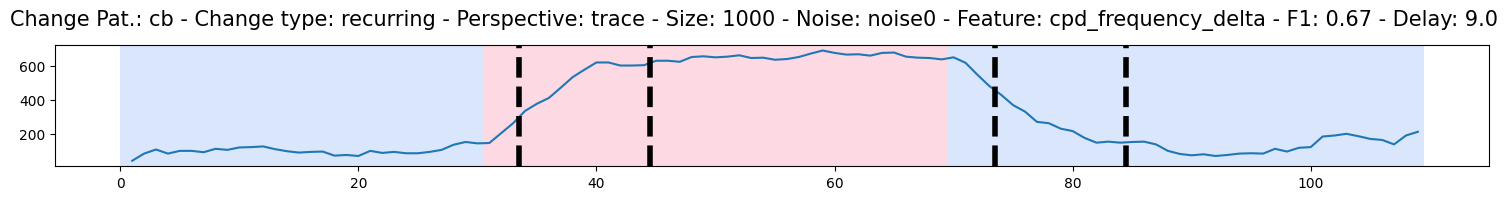

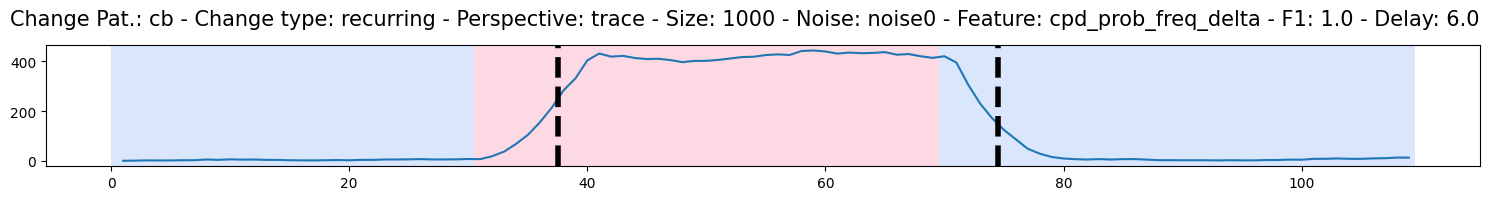

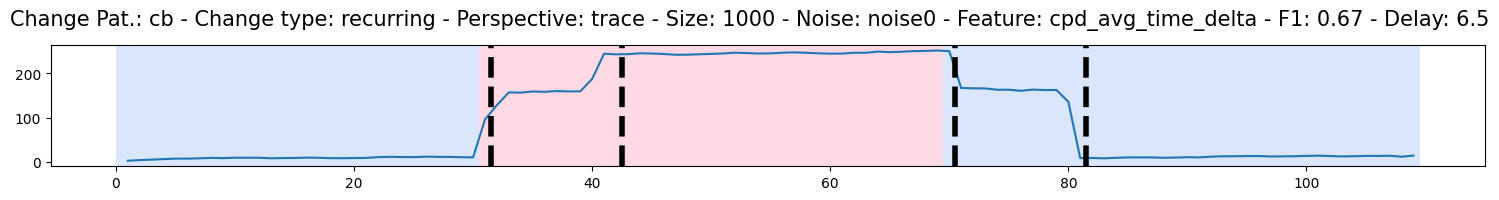

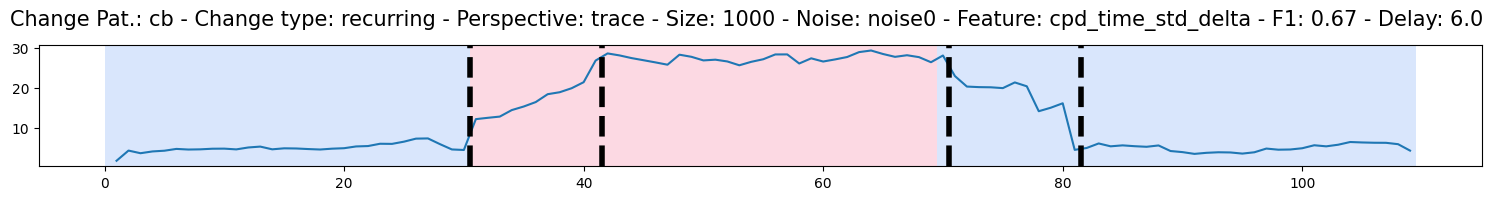

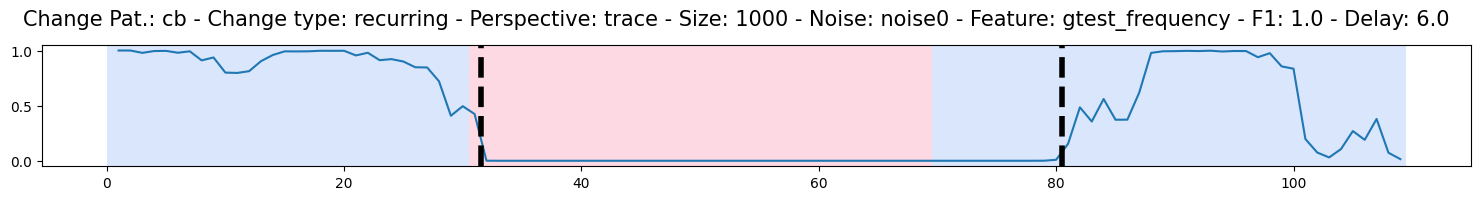

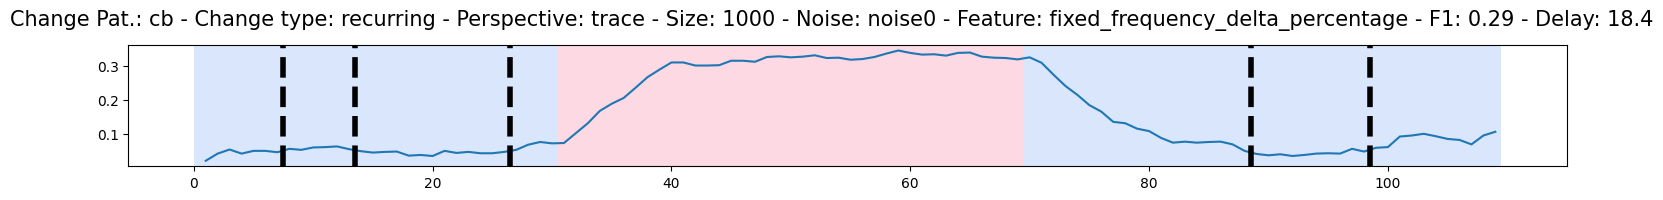

In [11]:
# Display Detection Task Results 
for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(signal = TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']]
                , true_chg_pts=ground_truth
                , computed_chg_pts = result.detection_results
                , computed_chg_pts_color = "k"
                , computed_chg_pts_linewidth = 4
                , computed_chg_pts_linestyle = "--"
                , computed_chg_pts_alpha = 1
                , figsize=(15, 2)
                )
    plt.suptitle("Change Pat.: " + log_path.split("/")[-1].split("_")[-1].split(".")[0]
                 + " - Change type: " + log_path.split("/")[-1].split("_")[-5].split("\\")[-1]
                 + " - Perspective: " + log_path.split("/")[-1].split("_")[-4]
                 + " - Size: " + log_path.split("/")[-1].split("_")[-2]
                 + " - Noise: " + log_path.split("/")[-1].split("_")[-3] 
                 + " - Feature: " + result.detection_feature
                 + " - F1: " + str(result.f1) 
                 + " - Delay: " + str(result.delay)
                 , fontsize=15)

    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

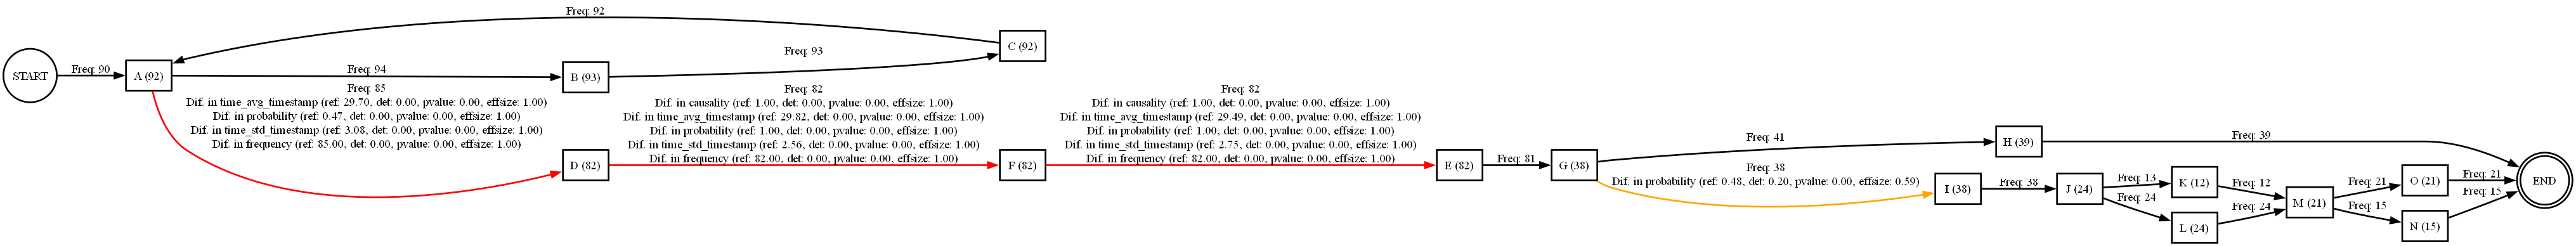

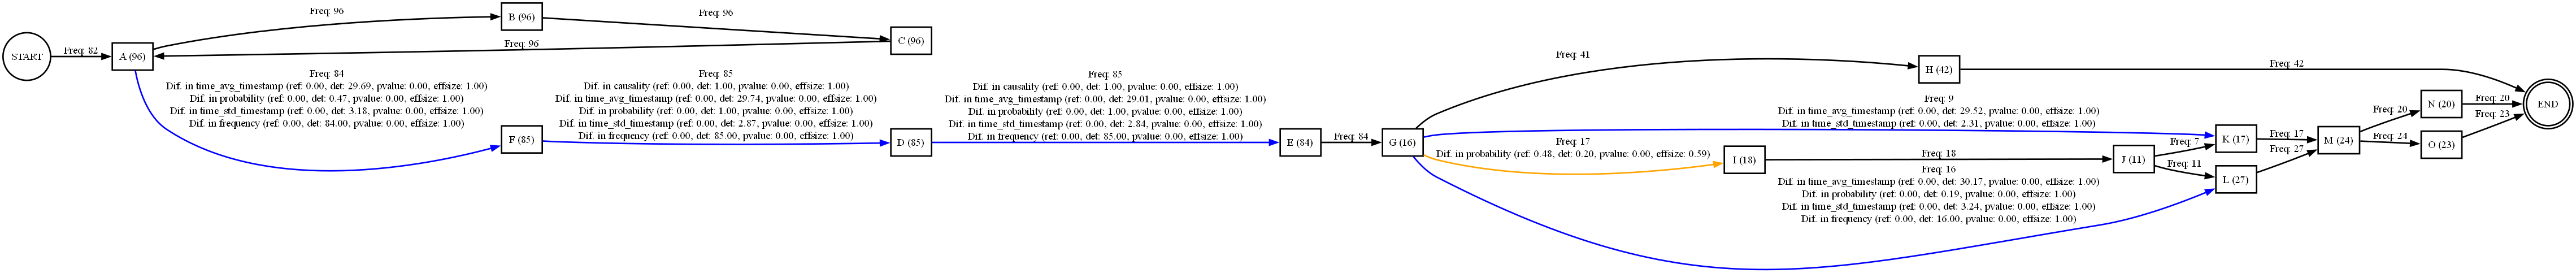

In [12]:
# Setting Localization Task
reference_window_index=0 
detection_window_index=55

TMPD_instance.set_localization_task(reference_window_index=reference_window_index, detection_window_index=detection_window_index, pvalue_threshold=0.05, effect_threshold=0.2, presence_percentage_threshold=0.01, pseudo_count=5)

# Executing Localization Task
TMPD_instance.run_localization_task()

# Showing Localization Task Results
significant_transition_changes, high_level_changes, reference_bpmn_text, detection_bpmn_text = TMPD_instance.get_localization_task(show_localization_dfg=True, show_original_dfg=False, show_original_bpmn=False)

In [13]:
significant_transition_changes

,transition,feature,perspective,transition_status,activity_status,p_value,effect_size,ref_value,det_value,dif_value
0,"(A, D)",time_avg_timestamp,time,deleted,no change,0.0000,1.0000,29.6967,0.0000,-29.6967
1,"(A, D)",probability,control_flow,deleted,no change,0.0000,1.0000,0.4749,0.0000,-0.4749
2,"(A, D)",time_std_timestamp,time,deleted,no change,0.0000,1.0000,3.0814,0.0000,-3.0814
3,"(A, D)",frequency,control_flow,deleted,no change,0.0000,1.0000,85.0000,0.0000,-85.0000
4,"(A, F)",time_avg_timestamp,time,new,no change,0.0000,1.0000,0.0000,29.6874,29.6874
5,"(A, F)",probability,control_flow,new,no change,0.0000,1.0000,0.0000,0.4667,0.4667
6,"(A, F)",time_std_timestamp,time,new,no change,0.0000,1.0000,0.0000,3.1762,3.1762
7,"(A, F)",frequency,control_flow,new,no change,0.0000,1.0000,0.0000,84.0000,84.0000
8,"(D, E)",causality,control_flow,new,no change,0.0000,1.0000,0.0000,1.0000,1.0000
9,"(D, E)",time_avg_timestamp,time,new,no change,0.0000,1.0000,0.0000,29.0089,29.0089


In [14]:
high_level_changes

{'Transitions with variations in causality': [('D', 'E'),
  ('D', 'F'),
  ('F', 'D'),
  ('F', 'E')],
 'Transitions with variations in time_avg_timestamp': [('A', 'D'),
  ('A', 'F'),
  ('D', 'E'),
  ('D', 'F'),
  ('F', 'D'),
  ('F', 'E'),
  ('G', 'K'),
  ('G', 'L')],
 'Transitions with variations in probability': [('A', 'D'),
  ('A', 'F'),
  ('D', 'E'),
  ('D', 'F'),
  ('F', 'D'),
  ('F', 'E'),
  ('G', 'I'),
  ('G', 'L')],
 'Transitions with variations in time_std_timestamp': [('A', 'D'),
  ('A', 'F'),
  ('D', 'E'),
  ('D', 'F'),
  ('F', 'D'),
  ('F', 'E'),
  ('G', 'K'),
  ('G', 'L')],
 'Transitions with variations in frequency': [('A', 'D'),
  ('A', 'F'),
  ('D', 'E'),
  ('D', 'F'),
  ('F', 'D'),
  ('F', 'E'),
  ('G', 'L')],
 'New transitions added to the process': [('D', 'E'),
  ('G', 'L'),
  ('G', 'K'),
  ('F', 'D'),
  ('A', 'F')],
 'Deleted transitions from the process': [('A', 'D'), ('F', 'E'), ('D', 'F')],
 'New activities added to the process': ['None'],
 'Deleted activities from

In [15]:
reference_bpmn_text, detection_bpmn_text

("Sequence( Loop( 'A', Sequence( 'B', 'C' ) ), 'D', 'F', 'E', 'G', Conditional( 'H', Sequence( 'I', 'J', Conditional( 'K', 'L' ), 'M', Conditional( 'N', 'O' ) ) ) )",
 "Sequence( Loop( 'A', Sequence( 'B', 'C' ) ), 'F', 'D', 'E', 'G', Conditional( 'H', Sequence( 'I', 'J', Conditional( 'K', 'L' ), 'M', Conditional( 'N', 'O' ) ) ) )")

## Step 6b - Setting Characterization Task

In [16]:
# Setting Characterization Task
# "gemini-2.5-flash", "gemini-2.5-pro", "gpt-4o", "gpt-4.1", "gpt-4.1-mini"
# TMPD_instance.set_characterization_task(llm_company = "openai", llm_model="gpt-4o", api_key_path='Temp/openai_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_general_approach.yaml')
TMPD_instance.set_characterization_task(llm_company = "google", llm_model="gemini-2.5-flash", api_key_path='Temp/google_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_general_approach.yaml')

# Executing Characterization Task
TMPD_instance.run_characterization_task()

# Showing Characterization Task Results
characterization_prompt, characterization_response = TMPD_instance.get_characterization_task()

In [17]:
print(characterization_prompt)


# Role and Goal
You are an expert process mining analyst specializing in concept drift characterization. Your objective is to deeply understand and explain the transformation observed between two versions of a business process (reference window and detection window). This includes identifying what changed, how the changes are interconnected, and what broader patterns and impacts they suggest — always grounded in the provided data sources.

**Your analysis must go beyond simply listing differences.** The user has access to the raw data and statistical tables. Your job is to interpret this information holistically, identify key insights, and present a coherent narrative that explains the *nature*, *scope*, and *interconnectedness* of the changes.

# Input Data
    - reference_transition_matrix: Transition matrix BEFORE change with columns:
        * activity_from, activity_to: transition identifiers (always available)
        * frequency, percentual: control-flow metrics (always availab

In [18]:
print(characterization_response)

The analysis reveals a targeted structural re-engineering of the business process, primarily affecting two distinct areas: a re-sequencing of activities within a specific branch and an expansion of choices at a key decision point. While the control-flow has been significantly altered, the time characteristics of the individual transitions remain remarkably consistent.

### 1. Integrated Change Characterization

#### Control-Flow Perspective

The most prominent changes are concentrated around two main areas of the process:

1.  **Re-sequencing of Activities D and F**: A significant structural re-arrangement has occurred in the sequence involving activities `D`, `E`, and `F`.
    *   **Deletion of the original path**: The transitions `(A, D)`, `(D, F)`, and `(F, E)` have been entirely removed from the process. This indicates the dismantling of the original sequence `A → D → F → E`.
    *   **Introduction of a new, reordered path**: Concurrently, new transitions `(A, F)`, `(F, D)`, and `(

## Step 6c - Setting Explanation Task

In [19]:
# TODO